In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'scale',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_fa',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 1000,
    'patience'      : 7,
    'dropout'       : 0.75,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_1000_075_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_fa_data_scale_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_1_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(631390, 828)
(631390, 1)
validation
(74368, 828)
(74368, 1)
test
(85358, 828)
(85358, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/632 [..............................] - ETA: 11:26 - loss: 0.0596 - STD: 1.2822e-04 - MAE: 0.2262

 10/632 [..............................] - ETA: 3s - loss: 0.0247 - STD: 1.7156e-04 - MAE: 0.1227   

 18/632 [..............................] - ETA: 3s - loss: 0.0194 - STD: 1.5492e-04 - MAE: 0.1068

 26/632 [>.............................] - ETA: 3s - loss: 0.0170 - STD: 1.5956e-04 - MAE: 0.1010

 35/632 [>.............................] - ETA: 3s - loss: 0.0153 - STD: 1.6926e-04 - MAE: 0.0946

 44/632 [=>............................] - ETA: 3s - loss: 0.0142 - STD: 1.9188e-04 - MAE: 0.0918

 53/632 [=>............................] - ETA: 3s - loss: 0.0135 - STD: 2.1849e-04 - MAE: 0.0893

 62/632 [=>............................] - ETA: 3s - loss: 0.0130 - STD: 2.5504e-04 - MAE: 0.0877

 71/632 [==>...........................] - ETA: 3s - loss: 0.0126 - STD: 3.0172e-04 - MAE: 0.0865

 80/632 [==>...........................] - ETA: 3s - loss: 0.0123 - STD: 3.6451e-04 - MAE: 0.0855

 89/632 [===>..........................] - ETA: 3s - loss: 0.0121 - STD: 4.4885e-04 - MAE: 0.0847

 98/632 [===>..........................] - ETA: 3s - loss: 0.0118 - STD: 5.7221e-04 - MAE: 0.0839

107/632 [====>.........................] - ETA: 3s - loss: 0.0117 - STD: 7.5646e-04 - MAE: 0.0835

115/632 [====>.........................] - ETA: 3s - loss: 0.0115 - STD: 0.0010 - MAE: 0.0830    

123/632 [====>.........................] - ETA: 3s - loss: 0.0114 - STD: 0.0014 - MAE: 0.0825

131/632 [=====>........................] - ETA: 3s - loss: 0.0112 - STD: 0.0020 - MAE: 0.0821

140/632 [=====>........................] - ETA: 3s - loss: 0.0111 - STD: 0.0030 - MAE: 0.0816

149/632 [======>.......................] - ETA: 3s - loss: 0.0109 - STD: 0.0046 - MAE: 0.0811

158/632 [======>.......................] - ETA: 2s - loss: 0.0108 - STD: 0.0063 - MAE: 0.0805

166/632 [======>.......................] - ETA: 2s - loss: 0.0106 - STD: 0.0078 - MAE: 0.0800

174/632 [=======>......................] - ETA: 2s - loss: 0.0105 - STD: 0.0092 - MAE: 0.0795

183/632 [=======>......................] - ETA: 2s - loss: 0.0104 - STD: 0.0107 - MAE: 0.0789

191/632 [========>.....................] - ETA: 2s - loss: 0.0103 - STD: 0.0121 - MAE: 0.0784

200/632 [========>.....................] - ETA: 2s - loss: 0.0101 - STD: 0.0135 - MAE: 0.0779

208/632 [========>.....................] - ETA: 2s - loss: 0.0100 - STD: 0.0147 - MAE: 0.0775

216/632 [=========>....................] - ETA: 2s - loss: 0.0099 - STD: 0.0160 - MAE: 0.0770

225/632 [=========>....................] - ETA: 2s - loss: 0.0098 - STD: 0.0171 - MAE: 0.0765

234/632 [==========>...................] - ETA: 2s - loss: 0.0097 - STD: 0.0184 - MAE: 0.0760

243/632 [==========>...................] - ETA: 2s - loss: 0.0096 - STD: 0.0198 - MAE: 0.0754

252/632 [==========>...................] - ETA: 2s - loss: 0.0095 - STD: 0.0212 - MAE: 0.0749

260/632 [===========>..................] - ETA: 2s - loss: 0.0094 - STD: 0.0223 - MAE: 0.0744

268/632 [===========>..................] - ETA: 2s - loss: 0.0093 - STD: 0.0234 - MAE: 0.0739

277/632 [============>.................] - ETA: 2s - loss: 0.0092 - STD: 0.0245 - MAE: 0.0734

286/632 [============>.................] - ETA: 2s - loss: 0.0090 - STD: 0.0256 - MAE: 0.0729

294/632 [============>.................] - ETA: 2s - loss: 0.0090 - STD: 0.0265 - MAE: 0.0724

303/632 [=============>................] - ETA: 2s - loss: 0.0089 - STD: 0.0275 - MAE: 0.0719

311/632 [=============>................] - ETA: 1s - loss: 0.0088 - STD: 0.0285 - MAE: 0.0716

319/632 [==============>...............] - ETA: 1s - loss: 0.0087 - STD: 0.0293 - MAE: 0.0712

327/632 [==============>...............] - ETA: 1s - loss: 0.0086 - STD: 0.0302 - MAE: 0.0708

336/632 [==============>...............] - ETA: 1s - loss: 0.0085 - STD: 0.0311 - MAE: 0.0704

345/632 [===============>..............] - ETA: 1s - loss: 0.0084 - STD: 0.0320 - MAE: 0.0699

354/632 [===============>..............] - ETA: 1s - loss: 0.0084 - STD: 0.0329 - MAE: 0.0695

363/632 [================>.............] - ETA: 1s - loss: 0.0083 - STD: 0.0337 - MAE: 0.0692

372/632 [================>.............] - ETA: 1s - loss: 0.0082 - STD: 0.0345 - MAE: 0.0688

380/632 [=================>............] - ETA: 1s - loss: 0.0081 - STD: 0.0352 - MAE: 0.0684

388/632 [=================>............] - ETA: 1s - loss: 0.0081 - STD: 0.0358 - MAE: 0.0681

396/632 [=================>............] - ETA: 1s - loss: 0.0080 - STD: 0.0365 - MAE: 0.0678

405/632 [==================>...........] - ETA: 1s - loss: 0.0079 - STD: 0.0372 - MAE: 0.0675

413/632 [==================>...........] - ETA: 1s - loss: 0.0079 - STD: 0.0378 - MAE: 0.0671

421/632 [==================>...........] - ETA: 1s - loss: 0.0078 - STD: 0.0384 - MAE: 0.0669

429/632 [===================>..........] - ETA: 1s - loss: 0.0078 - STD: 0.0389 - MAE: 0.0666

437/632 [===================>..........] - ETA: 1s - loss: 0.0077 - STD: 0.0395 - MAE: 0.0663

445/632 [====================>.........] - ETA: 1s - loss: 0.0077 - STD: 0.0400 - MAE: 0.0661

454/632 [====================>.........] - ETA: 1s - loss: 0.0076 - STD: 0.0406 - MAE: 0.0658

463/632 [====================>.........] - ETA: 1s - loss: 0.0076 - STD: 0.0411 - MAE: 0.0655

472/632 [=====================>........] - ETA: 1s - loss: 0.0075 - STD: 0.0416 - MAE: 0.0653

480/632 [=====================>........] - ETA: 0s - loss: 0.0075 - STD: 0.0421 - MAE: 0.0651

488/632 [======================>.......] - ETA: 0s - loss: 0.0074 - STD: 0.0426 - MAE: 0.0648

497/632 [======================>.......] - ETA: 0s - loss: 0.0074 - STD: 0.0431 - MAE: 0.0646

506/632 [=======================>......] - ETA: 0s - loss: 0.0073 - STD: 0.0435 - MAE: 0.0644

515/632 [=======================>......] - ETA: 0s - loss: 0.0073 - STD: 0.0440 - MAE: 0.0641

524/632 [=======================>......] - ETA: 0s - loss: 0.0072 - STD: 0.0444 - MAE: 0.0639

532/632 [========================>.....] - ETA: 0s - loss: 0.0072 - STD: 0.0448 - MAE: 0.0637

541/632 [========================>.....] - ETA: 0s - loss: 0.0072 - STD: 0.0453 - MAE: 0.0635

550/632 [=========================>....] - ETA: 0s - loss: 0.0071 - STD: 0.0457 - MAE: 0.0633

558/632 [=========================>....] - ETA: 0s - loss: 0.0071 - STD: 0.0461 - MAE: 0.0631

566/632 [=========================>....] - ETA: 0s - loss: 0.0071 - STD: 0.0464 - MAE: 0.0630

574/632 [==========================>...] - ETA: 0s - loss: 0.0070 - STD: 0.0468 - MAE: 0.0628

583/632 [==========================>...] - ETA: 0s - loss: 0.0070 - STD: 0.0471 - MAE: 0.0626

592/632 [===========================>..] - ETA: 0s - loss: 0.0070 - STD: 0.0475 - MAE: 0.0624

601/632 [===========================>..] - ETA: 0s - loss: 0.0069 - STD: 0.0479 - MAE: 0.0622

610/632 [===========================>..] - ETA: 0s - loss: 0.0069 - STD: 0.0482 - MAE: 0.0621

618/632 [============================>.] - ETA: 0s - loss: 0.0068 - STD: 0.0485 - MAE: 0.0619

621/632 [============================>.] - ETA: 0s - loss: 0.0068 - STD: 0.0486 - MAE: 0.0618

632/632 [==============================] - ETA: 0s - loss: 0.0068 - STD: 0.0490 - MAE: 0.0616

632/632 [==============================] - 6s 8ms/step - loss: 0.0068 - STD: 0.0490 - MAE: 0.0616 - val_loss: 0.0040 - val_STD: 0.0569 - val_MAE: 0.0472


Epoch 2/10000


  1/632 [..............................] - ETA: 16s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0478

  9/632 [..............................] - ETA: 4s - loss: 0.0044 - STD: 0.0720 - MAE: 0.0489 

 18/632 [..............................] - ETA: 3s - loss: 0.0044 - STD: 0.0727 - MAE: 0.0491

 26/632 [>.............................] - ETA: 3s - loss: 0.0044 - STD: 0.0725 - MAE: 0.0494

 34/632 [>.............................] - ETA: 3s - loss: 0.0045 - STD: 0.0725 - MAE: 0.0498

 42/632 [>.............................] - ETA: 3s - loss: 0.0045 - STD: 0.0725 - MAE: 0.0498

 51/632 [=>............................] - ETA: 3s - loss: 0.0045 - STD: 0.0726 - MAE: 0.0500

 60/632 [=>............................] - ETA: 3s - loss: 0.0045 - STD: 0.0723 - MAE: 0.0500

 69/632 [==>...........................] - ETA: 3s - loss: 0.0045 - STD: 0.0723 - MAE: 0.0500

 77/632 [==>...........................] - ETA: 3s - loss: 0.0046 - STD: 0.0722 - MAE: 0.0502

 86/632 [===>..........................] - ETA: 3s - loss: 0.0046 - STD: 0.0721 - MAE: 0.0504

 95/632 [===>..........................] - ETA: 3s - loss: 0.0046 - STD: 0.0719 - MAE: 0.0504

104/632 [===>..........................] - ETA: 3s - loss: 0.0046 - STD: 0.0717 - MAE: 0.0503

113/632 [====>.........................] - ETA: 3s - loss: 0.0046 - STD: 0.0716 - MAE: 0.0503

122/632 [====>.........................] - ETA: 3s - loss: 0.0046 - STD: 0.0716 - MAE: 0.0502

131/632 [=====>........................] - ETA: 3s - loss: 0.0046 - STD: 0.0717 - MAE: 0.0501

140/632 [=====>........................] - ETA: 3s - loss: 0.0046 - STD: 0.0717 - MAE: 0.0502

148/632 [======>.......................] - ETA: 3s - loss: 0.0045 - STD: 0.0718 - MAE: 0.0501

157/632 [======>.......................] - ETA: 2s - loss: 0.0045 - STD: 0.0719 - MAE: 0.0501

166/632 [======>.......................] - ETA: 2s - loss: 0.0045 - STD: 0.0721 - MAE: 0.0500

174/632 [=======>......................] - ETA: 2s - loss: 0.0045 - STD: 0.0722 - MAE: 0.0500

183/632 [=======>......................] - ETA: 2s - loss: 0.0045 - STD: 0.0722 - MAE: 0.0501

192/632 [========>.....................] - ETA: 2s - loss: 0.0045 - STD: 0.0722 - MAE: 0.0501

200/632 [========>.....................] - ETA: 2s - loss: 0.0045 - STD: 0.0722 - MAE: 0.0500

209/632 [========>.....................] - ETA: 2s - loss: 0.0045 - STD: 0.0722 - MAE: 0.0500

218/632 [=========>....................] - ETA: 2s - loss: 0.0045 - STD: 0.0724 - MAE: 0.0499

227/632 [=========>....................] - ETA: 2s - loss: 0.0045 - STD: 0.0725 - MAE: 0.0498

236/632 [==========>...................] - ETA: 2s - loss: 0.0045 - STD: 0.0726 - MAE: 0.0498

245/632 [==========>...................] - ETA: 2s - loss: 0.0045 - STD: 0.0726 - MAE: 0.0497

254/632 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0726 - MAE: 0.0497

263/632 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0727 - MAE: 0.0496

272/632 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0727 - MAE: 0.0496

281/632 [============>.................] - ETA: 2s - loss: 0.0045 - STD: 0.0728 - MAE: 0.0496

289/632 [============>.................] - ETA: 2s - loss: 0.0045 - STD: 0.0728 - MAE: 0.0496

297/632 [=============>................] - ETA: 2s - loss: 0.0045 - STD: 0.0728 - MAE: 0.0496

305/632 [=============>................] - ETA: 2s - loss: 0.0045 - STD: 0.0727 - MAE: 0.0496

314/632 [=============>................] - ETA: 1s - loss: 0.0045 - STD: 0.0728 - MAE: 0.0496

323/632 [==============>...............] - ETA: 1s - loss: 0.0045 - STD: 0.0727 - MAE: 0.0496

332/632 [==============>...............] - ETA: 1s - loss: 0.0045 - STD: 0.0728 - MAE: 0.0496

341/632 [===============>..............] - ETA: 1s - loss: 0.0045 - STD: 0.0727 - MAE: 0.0496

350/632 [===============>..............] - ETA: 1s - loss: 0.0045 - STD: 0.0727 - MAE: 0.0495

359/632 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0728 - MAE: 0.0495

368/632 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0728 - MAE: 0.0495

377/632 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0728 - MAE: 0.0495

386/632 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0727 - MAE: 0.0495

395/632 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0727 - MAE: 0.0495

404/632 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0728 - MAE: 0.0495

413/632 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0728 - MAE: 0.0495

422/632 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0728 - MAE: 0.0495

431/632 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0728 - MAE: 0.0494

440/632 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0728 - MAE: 0.0494

449/632 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0728 - MAE: 0.0494

458/632 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0729 - MAE: 0.0494

467/632 [=====================>........] - ETA: 1s - loss: 0.0044 - STD: 0.0729 - MAE: 0.0494

476/632 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0729 - MAE: 0.0494

485/632 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0730 - MAE: 0.0494

494/632 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0730 - MAE: 0.0493

503/632 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0730 - MAE: 0.0493

512/632 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0730 - MAE: 0.0493

521/632 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0731 - MAE: 0.0493

530/632 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0731 - MAE: 0.0493

539/632 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0731 - MAE: 0.0493

548/632 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0731 - MAE: 0.0492

557/632 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0732 - MAE: 0.0492

566/632 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0732 - MAE: 0.0492

575/632 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0732 - MAE: 0.0492

584/632 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0733 - MAE: 0.0492

592/632 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0733 - MAE: 0.0491

600/632 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0733 - MAE: 0.0491

609/632 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0733 - MAE: 0.0491

618/632 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0734 - MAE: 0.0490

627/632 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0734 - MAE: 0.0490

632/632 [==============================] - 4s 6ms/step - loss: 0.0044 - STD: 0.0734 - MAE: 0.0490 - val_loss: 0.0040 - val_STD: 0.0556 - val_MAE: 0.0457


Epoch 3/10000


  1/632 [..............................] - ETA: 14s - loss: 0.0042 - STD: 0.0727 - MAE: 0.0485

  9/632 [..............................] - ETA: 4s - loss: 0.0039 - STD: 0.0742 - MAE: 0.0466 

 18/632 [..............................] - ETA: 3s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0474

 27/632 [>.............................] - ETA: 3s - loss: 0.0042 - STD: 0.0756 - MAE: 0.0478

 36/632 [>.............................] - ETA: 3s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0479

 45/632 [=>............................] - ETA: 3s - loss: 0.0043 - STD: 0.0745 - MAE: 0.0483

 54/632 [=>............................] - ETA: 3s - loss: 0.0043 - STD: 0.0743 - MAE: 0.0482

 63/632 [=>............................] - ETA: 3s - loss: 0.0043 - STD: 0.0737 - MAE: 0.0484

 72/632 [==>...........................] - ETA: 3s - loss: 0.0043 - STD: 0.0736 - MAE: 0.0482

 81/632 [==>...........................] - ETA: 3s - loss: 0.0042 - STD: 0.0736 - MAE: 0.0481

 90/632 [===>..........................] - ETA: 3s - loss: 0.0042 - STD: 0.0738 - MAE: 0.0479

 99/632 [===>..........................] - ETA: 3s - loss: 0.0042 - STD: 0.0739 - MAE: 0.0478

108/632 [====>.........................] - ETA: 3s - loss: 0.0042 - STD: 0.0741 - MAE: 0.0478

117/632 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0744 - MAE: 0.0476

126/632 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0747 - MAE: 0.0476

135/632 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0747 - MAE: 0.0475

143/632 [=====>........................] - ETA: 2s - loss: 0.0041 - STD: 0.0748 - MAE: 0.0474

152/632 [======>.......................] - ETA: 2s - loss: 0.0041 - STD: 0.0748 - MAE: 0.0475

161/632 [======>.......................] - ETA: 2s - loss: 0.0041 - STD: 0.0748 - MAE: 0.0475

170/632 [=======>......................] - ETA: 2s - loss: 0.0041 - STD: 0.0748 - MAE: 0.0474

179/632 [=======>......................] - ETA: 2s - loss: 0.0041 - STD: 0.0750 - MAE: 0.0474

188/632 [=======>......................] - ETA: 2s - loss: 0.0041 - STD: 0.0750 - MAE: 0.0475

197/632 [========>.....................] - ETA: 2s - loss: 0.0041 - STD: 0.0750 - MAE: 0.0475

206/632 [========>.....................] - ETA: 2s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0474

215/632 [=========>....................] - ETA: 2s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0473

223/632 [=========>....................] - ETA: 2s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0473

232/632 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0473

241/632 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0473

250/632 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0473

259/632 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0473

268/632 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0473

277/632 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0473

286/632 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0473

295/632 [=============>................] - ETA: 2s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0473

303/632 [=============>................] - ETA: 1s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0473

312/632 [=============>................] - ETA: 1s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0473

321/632 [==============>...............] - ETA: 1s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0472

330/632 [==============>...............] - ETA: 1s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0472

339/632 [===============>..............] - ETA: 1s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0472

348/632 [===============>..............] - ETA: 1s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0472

356/632 [===============>..............] - ETA: 1s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0472

364/632 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0472

373/632 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0472

381/632 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0471

390/632 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0471

399/632 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0471

408/632 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0471

417/632 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0471

425/632 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0471

434/632 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0471

442/632 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0471

451/632 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0471

460/632 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0470

468/632 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0470

476/632 [=====================>........] - ETA: 0s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0471

485/632 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0471

494/632 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0471

503/632 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0471

512/632 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0471

521/632 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0471

530/632 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0471

539/632 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0471

548/632 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0470

557/632 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0470

566/632 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0470

574/632 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0470

582/632 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0470

590/632 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0470

599/632 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0470

608/632 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0470

617/632 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0469

625/632 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0469

632/632 [==============================] - 4s 6ms/step - loss: 0.0040 - STD: 0.0760 - MAE: 0.0469 - val_loss: 0.0038 - val_STD: 0.0590 - val_MAE: 0.0448


Epoch 4/10000


  1/632 [..............................] - ETA: 14s - loss: 0.0039 - STD: 0.0758 - MAE: 0.0452

 10/632 [..............................] - ETA: 3s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0456 

 18/632 [..............................] - ETA: 3s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0455

 26/632 [>.............................] - ETA: 3s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0454

 35/632 [>.............................] - ETA: 3s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0455

 44/632 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0454

 53/632 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0454

 62/632 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0457

 70/632 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0779 - MAE: 0.0460

 78/632 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0776 - MAE: 0.0461

 87/632 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0774 - MAE: 0.0460

 96/632 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0775 - MAE: 0.0459

105/632 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0775 - MAE: 0.0459

113/632 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0775 - MAE: 0.0459

121/632 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0775 - MAE: 0.0460

130/632 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0774 - MAE: 0.0460

139/632 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0460

148/632 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0460

157/632 [======>.......................] - ETA: 2s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0460

166/632 [======>.......................] - ETA: 2s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0461

175/632 [=======>......................] - ETA: 2s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0461

184/632 [=======>......................] - ETA: 2s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0461

193/632 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0461

202/632 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0461

211/632 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0462

220/632 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0461

229/632 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0461

237/632 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0461

246/632 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0461

254/632 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0461

263/632 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0460

272/632 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0460

281/632 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0460

290/632 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0460

298/632 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0460

307/632 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0459

316/632 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0459

324/632 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0459

333/632 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0774 - MAE: 0.0458

342/632 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0775 - MAE: 0.0458

351/632 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0775 - MAE: 0.0458

360/632 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0775 - MAE: 0.0458

369/632 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0775 - MAE: 0.0458

378/632 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0775 - MAE: 0.0458

387/632 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0458

396/632 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0457

405/632 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0457

413/632 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0457

422/632 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0457

431/632 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0457

440/632 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0457

449/632 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0457

458/632 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0457

467/632 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0456

475/632 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0456

483/632 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0456

492/632 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0456

500/632 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0456

508/632 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0456

517/632 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0456

525/632 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0456

533/632 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0456

542/632 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0456

551/632 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0456

560/632 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0456

569/632 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0456

577/632 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0456

586/632 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0456

594/632 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0456

603/632 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0456

612/632 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0456

620/632 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0455

629/632 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0455

632/632 [==============================] - 4s 7ms/step - loss: 0.0038 - STD: 0.0776 - MAE: 0.0455 - val_loss: 0.0036 - val_STD: 0.0616 - val_MAE: 0.0436


Epoch 5/10000


  1/632 [..............................] - ETA: 13s - loss: 0.0037 - STD: 0.0805 - MAE: 0.0434

  9/632 [..............................] - ETA: 3s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0456 

 18/632 [..............................] - ETA: 3s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0459

 27/632 [>.............................] - ETA: 3s - loss: 0.0038 - STD: 0.0767 - MAE: 0.0456

 36/632 [>.............................] - ETA: 3s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0453

 45/632 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0451

 54/632 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0453

 63/632 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0453

 72/632 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0451

 81/632 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0451

 90/632 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0450

 99/632 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0451

108/632 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0451

117/632 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0452

126/632 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0452

135/632 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0453

144/632 [=====>........................] - ETA: 2s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0454

153/632 [======>.......................] - ETA: 2s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0454

162/632 [======>.......................] - ETA: 2s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0455

170/632 [=======>......................] - ETA: 2s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0455

179/632 [=======>......................] - ETA: 2s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0455

188/632 [=======>......................] - ETA: 2s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0455

197/632 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0455

206/632 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0455

215/632 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0454

224/632 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0454

233/632 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0453

242/632 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0453

251/632 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0453

260/632 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0453

269/632 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0453

277/632 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0453

286/632 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0452

295/632 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0452

304/632 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0452

313/632 [=============>................] - ETA: 1s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0451

322/632 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0451

331/632 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0451

340/632 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0451

349/632 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0450

358/632 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0450

367/632 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0450

376/632 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0451

385/632 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0451

394/632 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0450

403/632 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0450

411/632 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0450

420/632 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0450

429/632 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0451

438/632 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0451

447/632 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0451

456/632 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0451

465/632 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0450

474/632 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0450

483/632 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0450

492/632 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0450

501/632 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0450

510/632 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0450

519/632 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0450

528/632 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0450

536/632 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0450

545/632 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0450

554/632 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0449

563/632 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0450

572/632 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0449

581/632 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0449

590/632 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0449

599/632 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0449

608/632 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0449

617/632 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0449

626/632 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0449

632/632 [==============================] - 4s 6ms/step - loss: 0.0037 - STD: 0.0780 - MAE: 0.0449 - val_loss: 0.0035 - val_STD: 0.0622 - val_MAE: 0.0432


Epoch 6/10000


  1/632 [..............................] - ETA: 16s - loss: 0.0031 - STD: 0.0755 - MAE: 0.0411

  9/632 [..............................] - ETA: 4s - loss: 0.0035 - STD: 0.0790 - MAE: 0.0438 

 18/632 [..............................] - ETA: 3s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0441

 27/632 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0443

 36/632 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0442

 45/632 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0444

 54/632 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0444

 62/632 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0444

 70/632 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0444

 79/632 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0442

 88/632 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0441

 97/632 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0441

106/632 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0442

115/632 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0442

124/632 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0443

133/632 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0444

142/632 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0443

151/632 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0444

160/632 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0444

167/632 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0444

173/632 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0444

178/632 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0444

185/632 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0443

193/632 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0443

200/632 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0443

208/632 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0444

216/632 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0444

225/632 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0444

233/632 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0444

240/632 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0444

248/632 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0444

257/632 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0444

266/632 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0444

275/632 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0443

283/632 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0443

291/632 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0442

300/632 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0442

309/632 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0442

318/632 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0442

327/632 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0442

336/632 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0442

345/632 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0441

354/632 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0441

363/632 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0441

372/632 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0441

380/632 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0441

388/632 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0441

396/632 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0441

405/632 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0441

414/632 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0441

422/632 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0441

429/632 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0441

437/632 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0441

445/632 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0441

454/632 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0441

461/632 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0440

469/632 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0440

478/632 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440

487/632 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440

496/632 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440

505/632 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440

514/632 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440

523/632 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440

532/632 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440

541/632 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440

550/632 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0439

559/632 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440

568/632 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0440

576/632 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0440

585/632 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0440

593/632 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0440

601/632 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0440

610/632 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0440

618/632 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0440

627/632 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0440

632/632 [==============================] - 4s 7ms/step - loss: 0.0036 - STD: 0.0787 - MAE: 0.0440 - val_loss: 0.0035 - val_STD: 0.0623 - val_MAE: 0.0430


Epoch 7/10000


  1/632 [..............................] - ETA: 19s - loss: 0.0032 - STD: 0.0782 - MAE: 0.0419

  9/632 [..............................] - ETA: 4s - loss: 0.0033 - STD: 0.0789 - MAE: 0.0428 

 18/632 [..............................] - ETA: 3s - loss: 0.0035 - STD: 0.0805 - MAE: 0.0433

 27/632 [>.............................] - ETA: 3s - loss: 0.0035 - STD: 0.0801 - MAE: 0.0432

 36/632 [>.............................] - ETA: 3s - loss: 0.0035 - STD: 0.0803 - MAE: 0.0432

 45/632 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0801 - MAE: 0.0434

 53/632 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0801 - MAE: 0.0434

 62/632 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0799 - MAE: 0.0437

 71/632 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0437

 80/632 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0439

 89/632 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0439

 97/632 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0439

106/632 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0438

115/632 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0439

124/632 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0439

132/632 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0439

140/632 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0439

149/632 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0439

158/632 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0438

166/632 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0438

174/632 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0437

182/632 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0437

190/632 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0437

197/632 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0437

205/632 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0437

212/632 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0437

220/632 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0437

228/632 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0437

236/632 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0437

244/632 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0437

253/632 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0437

262/632 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0437

271/632 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0437

279/632 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0437

287/632 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0437

296/632 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0437

305/632 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0436

314/632 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0436

323/632 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0436

332/632 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0436

341/632 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0436

350/632 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0436

359/632 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0435

368/632 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0435

377/632 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0435

386/632 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0435

395/632 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0435

404/632 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0435

413/632 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0435

422/632 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0435

431/632 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0435

439/632 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0435

447/632 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0434

455/632 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0434

464/632 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0434

473/632 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0434

482/632 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0434

490/632 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0434

499/632 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0434

508/632 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0434

517/632 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0434

526/632 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0434

535/632 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0434

544/632 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0434

553/632 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0434

562/632 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0434

571/632 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0434

580/632 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0434

589/632 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0433

598/632 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0433

607/632 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0433

616/632 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0433

625/632 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0433

632/632 [==============================] - 4s 7ms/step - loss: 0.0035 - STD: 0.0793 - MAE: 0.0433 - val_loss: 0.0035 - val_STD: 0.0638 - val_MAE: 0.0429


Epoch 8/10000


  1/632 [..............................] - ETA: 14s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0405

  9/632 [..............................] - ETA: 3s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0421 

 18/632 [..............................] - ETA: 3s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0427

 27/632 [>.............................] - ETA: 3s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0431

 35/632 [>.............................] - ETA: 3s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0433

 43/632 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0432

 52/632 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0432

 61/632 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0431

 69/632 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0431

 78/632 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0429

 87/632 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0430

 95/632 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0429

103/632 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0791 - MAE: 0.0428

112/632 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0791 - MAE: 0.0428

121/632 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0792 - MAE: 0.0428

129/632 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0791 - MAE: 0.0429

137/632 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0791 - MAE: 0.0429

146/632 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0791 - MAE: 0.0428

155/632 [======>.......................] - ETA: 2s - loss: 0.0034 - STD: 0.0791 - MAE: 0.0428

164/632 [======>.......................] - ETA: 2s - loss: 0.0034 - STD: 0.0792 - MAE: 0.0428

173/632 [=======>......................] - ETA: 2s - loss: 0.0034 - STD: 0.0792 - MAE: 0.0428

182/632 [=======>......................] - ETA: 2s - loss: 0.0034 - STD: 0.0792 - MAE: 0.0429

191/632 [========>.....................] - ETA: 2s - loss: 0.0034 - STD: 0.0792 - MAE: 0.0428

200/632 [========>.....................] - ETA: 2s - loss: 0.0034 - STD: 0.0792 - MAE: 0.0428

209/632 [========>.....................] - ETA: 2s - loss: 0.0034 - STD: 0.0792 - MAE: 0.0428

217/632 [=========>....................] - ETA: 2s - loss: 0.0034 - STD: 0.0793 - MAE: 0.0428

226/632 [=========>....................] - ETA: 2s - loss: 0.0034 - STD: 0.0794 - MAE: 0.0428

234/632 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0793 - MAE: 0.0428

243/632 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0793 - MAE: 0.0428

252/632 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0794 - MAE: 0.0428

261/632 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0794 - MAE: 0.0428

270/632 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0795 - MAE: 0.0428

279/632 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0795 - MAE: 0.0428

288/632 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0796 - MAE: 0.0428

297/632 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0796 - MAE: 0.0428

306/632 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0796 - MAE: 0.0428

315/632 [=============>................] - ETA: 1s - loss: 0.0034 - STD: 0.0796 - MAE: 0.0428

324/632 [==============>...............] - ETA: 1s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0428

333/632 [==============>...............] - ETA: 1s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0428

342/632 [===============>..............] - ETA: 1s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0428

351/632 [===============>..............] - ETA: 1s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0427

359/632 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0427

368/632 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0427

377/632 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0427

385/632 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0427

394/632 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0427

403/632 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0427

412/632 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0427

421/632 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0427

430/632 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0427

439/632 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0427

447/632 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0427

455/632 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0427

463/632 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0427

471/632 [=====================>........] - ETA: 0s - loss: 0.0034 - STD: 0.0799 - MAE: 0.0427

480/632 [=====================>........] - ETA: 0s - loss: 0.0034 - STD: 0.0799 - MAE: 0.0427

488/632 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0799 - MAE: 0.0427

496/632 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0799 - MAE: 0.0427

504/632 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0799 - MAE: 0.0427

512/632 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0799 - MAE: 0.0427

521/632 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0799 - MAE: 0.0427

530/632 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0799 - MAE: 0.0426

538/632 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0799 - MAE: 0.0426

547/632 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0799 - MAE: 0.0427

555/632 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0799 - MAE: 0.0426

563/632 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0799 - MAE: 0.0426

572/632 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0799 - MAE: 0.0426

581/632 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0799 - MAE: 0.0426

590/632 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0799 - MAE: 0.0426

599/632 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0426

607/632 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0426

615/632 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0426

623/632 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0426

632/632 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0426

632/632 [==============================] - 4s 7ms/step - loss: 0.0034 - STD: 0.0800 - MAE: 0.0426 - val_loss: 0.0038 - val_STD: 0.0679 - val_MAE: 0.0453


Epoch 9/10000


  1/632 [..............................] - ETA: 14s - loss: 0.0035 - STD: 0.0852 - MAE: 0.0451

  8/632 [..............................] - ETA: 4s - loss: 0.0033 - STD: 0.0784 - MAE: 0.0420 

 16/632 [..............................] - ETA: 4s - loss: 0.0033 - STD: 0.0796 - MAE: 0.0420

 25/632 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0802 - MAE: 0.0420

 34/632 [>.............................] - ETA: 3s - loss: 0.0033 - STD: 0.0803 - MAE: 0.0421

 43/632 [=>............................] - ETA: 3s - loss: 0.0033 - STD: 0.0802 - MAE: 0.0422

 52/632 [=>............................] - ETA: 3s - loss: 0.0033 - STD: 0.0802 - MAE: 0.0421

 61/632 [=>............................] - ETA: 3s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0422

 70/632 [==>...........................] - ETA: 3s - loss: 0.0034 - STD: 0.0805 - MAE: 0.0423

 79/632 [==>...........................] - ETA: 3s - loss: 0.0034 - STD: 0.0805 - MAE: 0.0422

 88/632 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0805 - MAE: 0.0423

 97/632 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0803 - MAE: 0.0423

106/632 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0804 - MAE: 0.0424

115/632 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0804 - MAE: 0.0424

124/632 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0806 - MAE: 0.0424

133/632 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0804 - MAE: 0.0424

142/632 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0804 - MAE: 0.0425

151/632 [======>.......................] - ETA: 2s - loss: 0.0034 - STD: 0.0803 - MAE: 0.0424

160/632 [======>.......................] - ETA: 2s - loss: 0.0034 - STD: 0.0801 - MAE: 0.0425

169/632 [=======>......................] - ETA: 2s - loss: 0.0034 - STD: 0.0801 - MAE: 0.0424

178/632 [=======>......................] - ETA: 2s - loss: 0.0034 - STD: 0.0801 - MAE: 0.0424

187/632 [=======>......................] - ETA: 2s - loss: 0.0034 - STD: 0.0801 - MAE: 0.0424

196/632 [========>.....................] - ETA: 2s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0423

205/632 [========>.....................] - ETA: 2s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0423

214/632 [=========>....................] - ETA: 2s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0423

223/632 [=========>....................] - ETA: 2s - loss: 0.0034 - STD: 0.0801 - MAE: 0.0423

232/632 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0423

241/632 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0423

250/632 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0423

259/632 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0423

268/632 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0801 - MAE: 0.0423

277/632 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0423

285/632 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0423

293/632 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0423

301/632 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0422

309/632 [=============>................] - ETA: 1s - loss: 0.0034 - STD: 0.0803 - MAE: 0.0422

318/632 [==============>...............] - ETA: 1s - loss: 0.0034 - STD: 0.0803 - MAE: 0.0422

326/632 [==============>...............] - ETA: 1s - loss: 0.0034 - STD: 0.0803 - MAE: 0.0422

335/632 [==============>...............] - ETA: 1s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0423

344/632 [===============>..............] - ETA: 1s - loss: 0.0034 - STD: 0.0801 - MAE: 0.0424

353/632 [===============>..............] - ETA: 1s - loss: 0.0034 - STD: 0.0801 - MAE: 0.0424

362/632 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0801 - MAE: 0.0424

370/632 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0801 - MAE: 0.0424

379/632 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0801 - MAE: 0.0424

388/632 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0801 - MAE: 0.0424

397/632 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0801 - MAE: 0.0424

406/632 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0801 - MAE: 0.0424

415/632 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0801 - MAE: 0.0424

424/632 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0801 - MAE: 0.0423

433/632 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0801 - MAE: 0.0423

441/632 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0801 - MAE: 0.0423

450/632 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0423

459/632 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0423

468/632 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0423

477/632 [=====================>........] - ETA: 0s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0423

486/632 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0423

495/632 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0423

504/632 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0423

513/632 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0423

522/632 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0423

531/632 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0423

540/632 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0423

549/632 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0423

558/632 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0423

567/632 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0423

576/632 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0423

585/632 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0803 - MAE: 0.0423

594/632 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0423

603/632 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0423

612/632 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0422

621/632 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0803 - MAE: 0.0422

630/632 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0803 - MAE: 0.0422

632/632 [==============================] - 4s 6ms/step - loss: 0.0034 - STD: 0.0803 - MAE: 0.0422 - val_loss: 0.0034 - val_STD: 0.0644 - val_MAE: 0.0418


Epoch 10/10000


  1/632 [..............................] - ETA: 15s - loss: 0.0032 - STD: 0.0819 - MAE: 0.0415

 10/632 [..............................] - ETA: 3s - loss: 0.0033 - STD: 0.0803 - MAE: 0.0416 

 19/632 [..............................] - ETA: 3s - loss: 0.0033 - STD: 0.0796 - MAE: 0.0416

 28/632 [>.............................] - ETA: 3s - loss: 0.0033 - STD: 0.0795 - MAE: 0.0420

 37/632 [>.............................] - ETA: 3s - loss: 0.0034 - STD: 0.0795 - MAE: 0.0422

 46/632 [=>............................] - ETA: 3s - loss: 0.0033 - STD: 0.0800 - MAE: 0.0421

 55/632 [=>............................] - ETA: 3s - loss: 0.0034 - STD: 0.0799 - MAE: 0.0422

 64/632 [==>...........................] - ETA: 3s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0422

 73/632 [==>...........................] - ETA: 3s - loss: 0.0034 - STD: 0.0796 - MAE: 0.0425

 82/632 [==>...........................] - ETA: 3s - loss: 0.0034 - STD: 0.0794 - MAE: 0.0426

 91/632 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0794 - MAE: 0.0425

100/632 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0795 - MAE: 0.0424

109/632 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0796 - MAE: 0.0422

118/632 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0798 - MAE: 0.0422

127/632 [=====>........................] - ETA: 2s - loss: 0.0033 - STD: 0.0799 - MAE: 0.0421

136/632 [=====>........................] - ETA: 2s - loss: 0.0033 - STD: 0.0800 - MAE: 0.0421

145/632 [=====>........................] - ETA: 2s - loss: 0.0033 - STD: 0.0801 - MAE: 0.0421

154/632 [======>.......................] - ETA: 2s - loss: 0.0033 - STD: 0.0801 - MAE: 0.0420

163/632 [======>.......................] - ETA: 2s - loss: 0.0033 - STD: 0.0801 - MAE: 0.0420

172/632 [=======>......................] - ETA: 2s - loss: 0.0033 - STD: 0.0801 - MAE: 0.0421

181/632 [=======>......................] - ETA: 2s - loss: 0.0033 - STD: 0.0800 - MAE: 0.0421

190/632 [========>.....................] - ETA: 2s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0421

199/632 [========>.....................] - ETA: 2s - loss: 0.0033 - STD: 0.0800 - MAE: 0.0421

208/632 [========>.....................] - ETA: 2s - loss: 0.0033 - STD: 0.0801 - MAE: 0.0421

217/632 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0802 - MAE: 0.0421

226/632 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0802 - MAE: 0.0420

235/632 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0803 - MAE: 0.0420

243/632 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0803 - MAE: 0.0420

252/632 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0803 - MAE: 0.0420

261/632 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0803 - MAE: 0.0420

270/632 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0803 - MAE: 0.0420

279/632 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0803 - MAE: 0.0420

288/632 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0803 - MAE: 0.0420

297/632 [=============>................] - ETA: 1s - loss: 0.0033 - STD: 0.0803 - MAE: 0.0420

306/632 [=============>................] - ETA: 1s - loss: 0.0033 - STD: 0.0803 - MAE: 0.0420

315/632 [=============>................] - ETA: 1s - loss: 0.0033 - STD: 0.0803 - MAE: 0.0420

324/632 [==============>...............] - ETA: 1s - loss: 0.0033 - STD: 0.0803 - MAE: 0.0420

333/632 [==============>...............] - ETA: 1s - loss: 0.0033 - STD: 0.0804 - MAE: 0.0419

342/632 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.0804 - MAE: 0.0419

351/632 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.0804 - MAE: 0.0419

360/632 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0804 - MAE: 0.0419

369/632 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0419

378/632 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0420

387/632 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0420

396/632 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0419

405/632 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0419

414/632 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0419

423/632 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0419

431/632 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0419

440/632 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0419

449/632 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0419

458/632 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0419

467/632 [=====================>........] - ETA: 0s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0419

476/632 [=====================>........] - ETA: 0s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0419

485/632 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0419

494/632 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0420

503/632 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0420

512/632 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0420

521/632 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0420

530/632 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0420

538/632 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0420

545/632 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0420

554/632 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0420

563/632 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0420

572/632 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0420

581/632 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0420

590/632 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0419

599/632 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0419

608/632 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0419

617/632 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0419

626/632 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0419

632/632 [==============================] - 4s 6ms/step - loss: 0.0033 - STD: 0.0806 - MAE: 0.0419 - val_loss: 0.0034 - val_STD: 0.0647 - val_MAE: 0.0426


Epoch 11/10000


  1/632 [..............................] - ETA: 13s - loss: 0.0030 - STD: 0.0820 - MAE: 0.0403

 10/632 [..............................] - ETA: 3s - loss: 0.0033 - STD: 0.0817 - MAE: 0.0416 

 19/632 [..............................] - ETA: 3s - loss: 0.0033 - STD: 0.0819 - MAE: 0.0417

 28/632 [>.............................] - ETA: 3s - loss: 0.0034 - STD: 0.0813 - MAE: 0.0423

 37/632 [>.............................] - ETA: 3s - loss: 0.0034 - STD: 0.0813 - MAE: 0.0424

 46/632 [=>............................] - ETA: 3s - loss: 0.0034 - STD: 0.0813 - MAE: 0.0425

 55/632 [=>............................] - ETA: 3s - loss: 0.0034 - STD: 0.0810 - MAE: 0.0423

 64/632 [==>...........................] - ETA: 3s - loss: 0.0034 - STD: 0.0808 - MAE: 0.0422

 72/632 [==>...........................] - ETA: 3s - loss: 0.0034 - STD: 0.0809 - MAE: 0.0422

 81/632 [==>...........................] - ETA: 3s - loss: 0.0034 - STD: 0.0808 - MAE: 0.0424

 90/632 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0807 - MAE: 0.0424

 99/632 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0806 - MAE: 0.0424

108/632 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0808 - MAE: 0.0423

117/632 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0422

126/632 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0421

135/632 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0421

144/632 [=====>........................] - ETA: 2s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0421

153/632 [======>.......................] - ETA: 2s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0421

162/632 [======>.......................] - ETA: 2s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0421

171/632 [=======>......................] - ETA: 2s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0421

180/632 [=======>......................] - ETA: 2s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0420

189/632 [=======>......................] - ETA: 2s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0420

198/632 [========>.....................] - ETA: 2s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0420

207/632 [========>.....................] - ETA: 2s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0420

216/632 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0419

225/632 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0419

234/632 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0419

243/632 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0809 - MAE: 0.0418

252/632 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0809 - MAE: 0.0419

261/632 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0809 - MAE: 0.0418

270/632 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0809 - MAE: 0.0418

279/632 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0418

288/632 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0809 - MAE: 0.0418

297/632 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0418

306/632 [=============>................] - ETA: 1s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0418

315/632 [=============>................] - ETA: 1s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0418

324/632 [==============>...............] - ETA: 1s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0418

333/632 [==============>...............] - ETA: 1s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0419

342/632 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0419

351/632 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0419

360/632 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0419

369/632 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0419

378/632 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0419

387/632 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0419

396/632 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0418

405/632 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0418

414/632 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0418

423/632 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0418

432/632 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0418

441/632 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0418

450/632 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0418

459/632 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0417

468/632 [=====================>........] - ETA: 0s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0417

477/632 [=====================>........] - ETA: 0s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0417

486/632 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0417

495/632 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0417

504/632 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0417

513/632 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0417

522/632 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0418

531/632 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0418

540/632 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0418

549/632 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0417

558/632 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0418

568/632 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0418

577/632 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0418

586/632 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0418

595/632 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0418

604/632 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0418

613/632 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0418

622/632 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0418

631/632 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0418

632/632 [==============================] - 4s 6ms/step - loss: 0.0033 - STD: 0.0806 - MAE: 0.0418 - val_loss: 0.0034 - val_STD: 0.0642 - val_MAE: 0.0424


Epoch 12/10000


  1/632 [..............................] - ETA: 13s - loss: 0.0028 - STD: 0.0828 - MAE: 0.0395

  9/632 [..............................] - ETA: 4s - loss: 0.0032 - STD: 0.0816 - MAE: 0.0413 

 18/632 [..............................] - ETA: 3s - loss: 0.0032 - STD: 0.0817 - MAE: 0.0415

 27/632 [>.............................] - ETA: 3s - loss: 0.0033 - STD: 0.0804 - MAE: 0.0416

 36/632 [>.............................] - ETA: 3s - loss: 0.0032 - STD: 0.0801 - MAE: 0.0415

 45/632 [=>............................] - ETA: 3s - loss: 0.0032 - STD: 0.0804 - MAE: 0.0416

 54/632 [=>............................] - ETA: 3s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0417

 63/632 [=>............................] - ETA: 3s - loss: 0.0033 - STD: 0.0809 - MAE: 0.0416

 72/632 [==>...........................] - ETA: 3s - loss: 0.0032 - STD: 0.0811 - MAE: 0.0415

 81/632 [==>...........................] - ETA: 3s - loss: 0.0032 - STD: 0.0812 - MAE: 0.0414

 90/632 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0812 - MAE: 0.0414

 99/632 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0812 - MAE: 0.0414

108/632 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0811 - MAE: 0.0414

117/632 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0812 - MAE: 0.0414

126/632 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0811 - MAE: 0.0413

135/632 [=====>........................] - ETA: 2s - loss: 0.0032 - STD: 0.0811 - MAE: 0.0413

145/632 [=====>........................] - ETA: 2s - loss: 0.0032 - STD: 0.0811 - MAE: 0.0413

154/632 [======>.......................] - ETA: 2s - loss: 0.0032 - STD: 0.0811 - MAE: 0.0413

163/632 [======>.......................] - ETA: 2s - loss: 0.0032 - STD: 0.0810 - MAE: 0.0413

172/632 [=======>......................] - ETA: 2s - loss: 0.0032 - STD: 0.0810 - MAE: 0.0413

181/632 [=======>......................] - ETA: 2s - loss: 0.0032 - STD: 0.0811 - MAE: 0.0413

190/632 [========>.....................] - ETA: 2s - loss: 0.0032 - STD: 0.0810 - MAE: 0.0413

199/632 [========>.....................] - ETA: 2s - loss: 0.0032 - STD: 0.0810 - MAE: 0.0413

208/632 [========>.....................] - ETA: 2s - loss: 0.0032 - STD: 0.0811 - MAE: 0.0413

217/632 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0810 - MAE: 0.0413

226/632 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0809 - MAE: 0.0413

235/632 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0810 - MAE: 0.0413

244/632 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0811 - MAE: 0.0413

253/632 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0810 - MAE: 0.0413

262/632 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0810 - MAE: 0.0413

271/632 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0810 - MAE: 0.0413

280/632 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0809 - MAE: 0.0414

289/632 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0809 - MAE: 0.0413

298/632 [=============>................] - ETA: 1s - loss: 0.0032 - STD: 0.0809 - MAE: 0.0413

307/632 [=============>................] - ETA: 1s - loss: 0.0032 - STD: 0.0809 - MAE: 0.0414

316/632 [==============>...............] - ETA: 1s - loss: 0.0032 - STD: 0.0809 - MAE: 0.0414

325/632 [==============>...............] - ETA: 1s - loss: 0.0032 - STD: 0.0809 - MAE: 0.0414

334/632 [==============>...............] - ETA: 1s - loss: 0.0032 - STD: 0.0809 - MAE: 0.0414

343/632 [===============>..............] - ETA: 1s - loss: 0.0032 - STD: 0.0809 - MAE: 0.0414

352/632 [===============>..............] - ETA: 1s - loss: 0.0032 - STD: 0.0810 - MAE: 0.0414

361/632 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0810 - MAE: 0.0414

370/632 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0809 - MAE: 0.0414

379/632 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0809 - MAE: 0.0414

388/632 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0809 - MAE: 0.0414

397/632 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0809 - MAE: 0.0414

406/632 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0809 - MAE: 0.0414

415/632 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0808 - MAE: 0.0414

424/632 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0808 - MAE: 0.0414

433/632 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0809 - MAE: 0.0414

442/632 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0809 - MAE: 0.0414

451/632 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0809 - MAE: 0.0414

460/632 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0809 - MAE: 0.0414

469/632 [=====================>........] - ETA: 0s - loss: 0.0032 - STD: 0.0809 - MAE: 0.0413

478/632 [=====================>........] - ETA: 0s - loss: 0.0032 - STD: 0.0809 - MAE: 0.0413

487/632 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0809 - MAE: 0.0413

496/632 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0810 - MAE: 0.0413

505/632 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0810 - MAE: 0.0413

514/632 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0810 - MAE: 0.0413

523/632 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0810 - MAE: 0.0413

532/632 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0811 - MAE: 0.0413

541/632 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0811 - MAE: 0.0413

550/632 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0811 - MAE: 0.0413

559/632 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0811 - MAE: 0.0413

568/632 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0811 - MAE: 0.0413

577/632 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0811 - MAE: 0.0413

586/632 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0811 - MAE: 0.0413

595/632 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0811 - MAE: 0.0413

604/632 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0811 - MAE: 0.0412

613/632 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0811 - MAE: 0.0412

622/632 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0812 - MAE: 0.0412

631/632 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0812 - MAE: 0.0412

632/632 [==============================] - 4s 6ms/step - loss: 0.0032 - STD: 0.0812 - MAE: 0.0412 - val_loss: 0.0036 - val_STD: 0.0622 - val_MAE: 0.0428


Epoch 13/10000


  1/632 [..............................] - ETA: 13s - loss: 0.0036 - STD: 0.0762 - MAE: 0.0421

 10/632 [..............................] - ETA: 3s - loss: 0.0032 - STD: 0.0810 - MAE: 0.0410 

 19/632 [..............................] - ETA: 3s - loss: 0.0032 - STD: 0.0819 - MAE: 0.0410

 28/632 [>.............................] - ETA: 3s - loss: 0.0032 - STD: 0.0816 - MAE: 0.0410

 37/632 [>.............................] - ETA: 3s - loss: 0.0032 - STD: 0.0816 - MAE: 0.0409

 46/632 [=>............................] - ETA: 3s - loss: 0.0032 - STD: 0.0814 - MAE: 0.0409

 55/632 [=>............................] - ETA: 3s - loss: 0.0032 - STD: 0.0816 - MAE: 0.0409

 64/632 [==>...........................] - ETA: 3s - loss: 0.0032 - STD: 0.0814 - MAE: 0.0410

 73/632 [==>...........................] - ETA: 3s - loss: 0.0032 - STD: 0.0812 - MAE: 0.0412

 82/632 [==>...........................] - ETA: 3s - loss: 0.0032 - STD: 0.0813 - MAE: 0.0411

 91/632 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0812 - MAE: 0.0411

100/632 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0812 - MAE: 0.0411

108/632 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0813 - MAE: 0.0411

117/632 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0811 - MAE: 0.0411

126/632 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0812 - MAE: 0.0411

135/632 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0811 - MAE: 0.0411

144/632 [=====>........................] - ETA: 2s - loss: 0.0032 - STD: 0.0811 - MAE: 0.0411

153/632 [======>.......................] - ETA: 2s - loss: 0.0032 - STD: 0.0811 - MAE: 0.0411

162/632 [======>.......................] - ETA: 2s - loss: 0.0032 - STD: 0.0811 - MAE: 0.0411

171/632 [=======>......................] - ETA: 2s - loss: 0.0032 - STD: 0.0812 - MAE: 0.0411

180/632 [=======>......................] - ETA: 2s - loss: 0.0032 - STD: 0.0811 - MAE: 0.0410

189/632 [=======>......................] - ETA: 2s - loss: 0.0032 - STD: 0.0812 - MAE: 0.0410

198/632 [========>.....................] - ETA: 2s - loss: 0.0032 - STD: 0.0812 - MAE: 0.0410

207/632 [========>.....................] - ETA: 2s - loss: 0.0032 - STD: 0.0811 - MAE: 0.0411

216/632 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0810 - MAE: 0.0411

225/632 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0810 - MAE: 0.0411

234/632 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0810 - MAE: 0.0411

243/632 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0811 - MAE: 0.0411

252/632 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0811 - MAE: 0.0411

260/632 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0810 - MAE: 0.0412

269/632 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0811 - MAE: 0.0411

278/632 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0811 - MAE: 0.0411

287/632 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0812 - MAE: 0.0411

296/632 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0812 - MAE: 0.0411

305/632 [=============>................] - ETA: 1s - loss: 0.0032 - STD: 0.0812 - MAE: 0.0411

314/632 [=============>................] - ETA: 1s - loss: 0.0032 - STD: 0.0812 - MAE: 0.0411

323/632 [==============>...............] - ETA: 1s - loss: 0.0032 - STD: 0.0812 - MAE: 0.0411

332/632 [==============>...............] - ETA: 1s - loss: 0.0032 - STD: 0.0812 - MAE: 0.0411

341/632 [===============>..............] - ETA: 1s - loss: 0.0032 - STD: 0.0813 - MAE: 0.0411

350/632 [===============>..............] - ETA: 1s - loss: 0.0032 - STD: 0.0813 - MAE: 0.0411

359/632 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0813 - MAE: 0.0411

368/632 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0813 - MAE: 0.0411

377/632 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0813 - MAE: 0.0410

386/632 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0813 - MAE: 0.0410

395/632 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0813 - MAE: 0.0410

404/632 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0813 - MAE: 0.0410

413/632 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0814 - MAE: 0.0410

422/632 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0814 - MAE: 0.0410

431/632 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0814 - MAE: 0.0410

440/632 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0815 - MAE: 0.0409

449/632 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0815 - MAE: 0.0410

458/632 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0814 - MAE: 0.0410

466/632 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0814 - MAE: 0.0410

475/632 [=====================>........] - ETA: 0s - loss: 0.0032 - STD: 0.0814 - MAE: 0.0409

484/632 [=====================>........] - ETA: 0s - loss: 0.0032 - STD: 0.0815 - MAE: 0.0409

493/632 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0815 - MAE: 0.0410

501/632 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0815 - MAE: 0.0410

509/632 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0815 - MAE: 0.0410

518/632 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0815 - MAE: 0.0410

526/632 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0815 - MAE: 0.0410

535/632 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0815 - MAE: 0.0410

544/632 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0815 - MAE: 0.0410

553/632 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0814 - MAE: 0.0410

561/632 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0814 - MAE: 0.0410

570/632 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0814 - MAE: 0.0410

579/632 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0814 - MAE: 0.0410

587/632 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0814 - MAE: 0.0410

595/632 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0814 - MAE: 0.0410

604/632 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0814 - MAE: 0.0410

612/632 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0814 - MAE: 0.0409

620/632 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0815 - MAE: 0.0409

629/632 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0815 - MAE: 0.0409

632/632 [==============================] - 4s 6ms/step - loss: 0.0032 - STD: 0.0815 - MAE: 0.0409 - val_loss: 0.0034 - val_STD: 0.0639 - val_MAE: 0.0423


Epoch 14/10000


  1/632 [..............................] - ETA: 19s - loss: 0.0034 - STD: 0.0795 - MAE: 0.0408

  7/632 [..............................] - ETA: 5s - loss: 0.0030 - STD: 0.0841 - MAE: 0.0401 

 15/632 [..............................] - ETA: 4s - loss: 0.0032 - STD: 0.0822 - MAE: 0.0410

 24/632 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0813 - MAE: 0.0406

 33/632 [>.............................] - ETA: 3s - loss: 0.0032 - STD: 0.0810 - MAE: 0.0408

 42/632 [>.............................] - ETA: 3s - loss: 0.0032 - STD: 0.0810 - MAE: 0.0407

 51/632 [=>............................] - ETA: 3s - loss: 0.0032 - STD: 0.0814 - MAE: 0.0409

 59/632 [=>............................] - ETA: 3s - loss: 0.0032 - STD: 0.0817 - MAE: 0.0409

 67/632 [==>...........................] - ETA: 3s - loss: 0.0032 - STD: 0.0814 - MAE: 0.0410

 76/632 [==>...........................] - ETA: 3s - loss: 0.0032 - STD: 0.0816 - MAE: 0.0409

 85/632 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0817 - MAE: 0.0408

 94/632 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0816 - MAE: 0.0408

103/632 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0816 - MAE: 0.0408

112/632 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0813 - MAE: 0.0409

121/632 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0814 - MAE: 0.0408

130/632 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0816 - MAE: 0.0407

139/632 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0817 - MAE: 0.0407

147/632 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0817 - MAE: 0.0407

156/632 [======>.......................] - ETA: 2s - loss: 0.0032 - STD: 0.0816 - MAE: 0.0408

165/632 [======>.......................] - ETA: 2s - loss: 0.0032 - STD: 0.0815 - MAE: 0.0409

174/632 [=======>......................] - ETA: 2s - loss: 0.0032 - STD: 0.0814 - MAE: 0.0409

183/632 [=======>......................] - ETA: 2s - loss: 0.0032 - STD: 0.0815 - MAE: 0.0410

192/632 [========>.....................] - ETA: 2s - loss: 0.0032 - STD: 0.0815 - MAE: 0.0410

201/632 [========>.....................] - ETA: 2s - loss: 0.0032 - STD: 0.0815 - MAE: 0.0410

210/632 [========>.....................] - ETA: 2s - loss: 0.0032 - STD: 0.0816 - MAE: 0.0410

219/632 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0815 - MAE: 0.0410

228/632 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0814 - MAE: 0.0409

237/632 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0814 - MAE: 0.0410

246/632 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0814 - MAE: 0.0409

255/632 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0814 - MAE: 0.0410

264/632 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0814 - MAE: 0.0410

273/632 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0813 - MAE: 0.0409

282/632 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0814 - MAE: 0.0410

291/632 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0813 - MAE: 0.0410

300/632 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0813 - MAE: 0.0410

309/632 [=============>................] - ETA: 1s - loss: 0.0032 - STD: 0.0813 - MAE: 0.0410

318/632 [==============>...............] - ETA: 1s - loss: 0.0032 - STD: 0.0813 - MAE: 0.0410

327/632 [==============>...............] - ETA: 1s - loss: 0.0032 - STD: 0.0813 - MAE: 0.0410

336/632 [==============>...............] - ETA: 1s - loss: 0.0032 - STD: 0.0813 - MAE: 0.0409

345/632 [===============>..............] - ETA: 1s - loss: 0.0032 - STD: 0.0814 - MAE: 0.0409

354/632 [===============>..............] - ETA: 1s - loss: 0.0032 - STD: 0.0813 - MAE: 0.0409

363/632 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0813 - MAE: 0.0409

372/632 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0813 - MAE: 0.0409

381/632 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0813 - MAE: 0.0409

390/632 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0813 - MAE: 0.0409

398/632 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0812 - MAE: 0.0409

407/632 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0813 - MAE: 0.0409

416/632 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0813 - MAE: 0.0409

425/632 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0813 - MAE: 0.0409

434/632 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0813 - MAE: 0.0409

443/632 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0813 - MAE: 0.0409

452/632 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0814 - MAE: 0.0409

461/632 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0813 - MAE: 0.0409

470/632 [=====================>........] - ETA: 0s - loss: 0.0032 - STD: 0.0813 - MAE: 0.0409

478/632 [=====================>........] - ETA: 0s - loss: 0.0032 - STD: 0.0813 - MAE: 0.0409

487/632 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0812 - MAE: 0.0409

495/632 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0812 - MAE: 0.0409

504/632 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0813 - MAE: 0.0409

513/632 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0813 - MAE: 0.0409

522/632 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0813 - MAE: 0.0409

531/632 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0813 - MAE: 0.0409

540/632 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0813 - MAE: 0.0409

549/632 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0813 - MAE: 0.0409

558/632 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0813 - MAE: 0.0409

567/632 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0814 - MAE: 0.0408

576/632 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0814 - MAE: 0.0408

585/632 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0814 - MAE: 0.0408

594/632 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0814 - MAE: 0.0408

603/632 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0815 - MAE: 0.0408

612/632 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0815 - MAE: 0.0408

621/632 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0814 - MAE: 0.0408

630/632 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0815 - MAE: 0.0408

632/632 [==============================] - 4s 6ms/step - loss: 0.0032 - STD: 0.0815 - MAE: 0.0408 - val_loss: 0.0035 - val_STD: 0.0608 - val_MAE: 0.0424


Epoch 15/10000


  1/632 [..............................] - ETA: 15s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0418

  8/632 [..............................] - ETA: 4s - loss: 0.0031 - STD: 0.0819 - MAE: 0.0408 

 17/632 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.0829 - MAE: 0.0402

 25/632 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0832 - MAE: 0.0398

 34/632 [>.............................] - ETA: 3s - loss: 0.0030 - STD: 0.0826 - MAE: 0.0401

 43/632 [=>............................] - ETA: 3s - loss: 0.0031 - STD: 0.0822 - MAE: 0.0402

 52/632 [=>............................] - ETA: 3s - loss: 0.0030 - STD: 0.0824 - MAE: 0.0401

 61/632 [=>............................] - ETA: 3s - loss: 0.0030 - STD: 0.0821 - MAE: 0.0401

 70/632 [==>...........................] - ETA: 3s - loss: 0.0030 - STD: 0.0820 - MAE: 0.0402

 79/632 [==>...........................] - ETA: 3s - loss: 0.0030 - STD: 0.0822 - MAE: 0.0401

 88/632 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0822 - MAE: 0.0402

 97/632 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0822 - MAE: 0.0402

106/632 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0820 - MAE: 0.0403

115/632 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0818 - MAE: 0.0404

124/632 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0819 - MAE: 0.0403

133/632 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0819 - MAE: 0.0403

142/632 [=====>........................] - ETA: 2s - loss: 0.0031 - STD: 0.0819 - MAE: 0.0404

151/632 [======>.......................] - ETA: 2s - loss: 0.0031 - STD: 0.0819 - MAE: 0.0403

160/632 [======>.......................] - ETA: 2s - loss: 0.0031 - STD: 0.0820 - MAE: 0.0403

169/632 [=======>......................] - ETA: 2s - loss: 0.0031 - STD: 0.0819 - MAE: 0.0403

178/632 [=======>......................] - ETA: 2s - loss: 0.0031 - STD: 0.0819 - MAE: 0.0403

187/632 [=======>......................] - ETA: 2s - loss: 0.0031 - STD: 0.0819 - MAE: 0.0403

196/632 [========>.....................] - ETA: 2s - loss: 0.0031 - STD: 0.0818 - MAE: 0.0403

205/632 [========>.....................] - ETA: 2s - loss: 0.0031 - STD: 0.0819 - MAE: 0.0403

214/632 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0819 - MAE: 0.0403

223/632 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0819 - MAE: 0.0403

232/632 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0819 - MAE: 0.0403

241/632 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0818 - MAE: 0.0403

250/632 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0819 - MAE: 0.0404

259/632 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0819 - MAE: 0.0403

268/632 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0820 - MAE: 0.0403

277/632 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0820 - MAE: 0.0403

286/632 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0820 - MAE: 0.0403

295/632 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0820 - MAE: 0.0403

304/632 [=============>................] - ETA: 1s - loss: 0.0031 - STD: 0.0820 - MAE: 0.0403

313/632 [=============>................] - ETA: 1s - loss: 0.0031 - STD: 0.0821 - MAE: 0.0403

322/632 [==============>...............] - ETA: 1s - loss: 0.0031 - STD: 0.0821 - MAE: 0.0403

331/632 [==============>...............] - ETA: 1s - loss: 0.0031 - STD: 0.0821 - MAE: 0.0403

340/632 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.0821 - MAE: 0.0403

349/632 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.0821 - MAE: 0.0403

358/632 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.0821 - MAE: 0.0403

367/632 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0822 - MAE: 0.0403

376/632 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0821 - MAE: 0.0403

385/632 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0821 - MAE: 0.0403

394/632 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0821 - MAE: 0.0403

403/632 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0821 - MAE: 0.0403

412/632 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0821 - MAE: 0.0403

421/632 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0821 - MAE: 0.0403

430/632 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0821 - MAE: 0.0403

439/632 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0821 - MAE: 0.0403

448/632 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0821 - MAE: 0.0403

457/632 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0820 - MAE: 0.0403

466/632 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0820 - MAE: 0.0403

475/632 [=====================>........] - ETA: 0s - loss: 0.0031 - STD: 0.0821 - MAE: 0.0403

484/632 [=====================>........] - ETA: 0s - loss: 0.0031 - STD: 0.0821 - MAE: 0.0403

493/632 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0821 - MAE: 0.0403

502/632 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0821 - MAE: 0.0403

511/632 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0821 - MAE: 0.0403

520/632 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0821 - MAE: 0.0403

529/632 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0822 - MAE: 0.0402

538/632 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0821 - MAE: 0.0402

547/632 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0821 - MAE: 0.0402

556/632 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0821 - MAE: 0.0402

565/632 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0821 - MAE: 0.0402

574/632 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0821 - MAE: 0.0402

583/632 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0821 - MAE: 0.0402

592/632 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0821 - MAE: 0.0402

601/632 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0821 - MAE: 0.0402

610/632 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0821 - MAE: 0.0402

619/632 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0821 - MAE: 0.0402

628/632 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0821 - MAE: 0.0402

632/632 [==============================] - 4s 6ms/step - loss: 0.0031 - STD: 0.0821 - MAE: 0.0402 - val_loss: 0.0036 - val_STD: 0.0594 - val_MAE: 0.0428


Epoch 16/10000


  1/632 [..............................] - ETA: 15s - loss: 0.0034 - STD: 0.0769 - MAE: 0.0412

  8/632 [..............................] - ETA: 4s - loss: 0.0032 - STD: 0.0808 - MAE: 0.0409 

 16/632 [..............................] - ETA: 4s - loss: 0.0032 - STD: 0.0810 - MAE: 0.0408

 25/632 [>.............................] - ETA: 3s - loss: 0.0031 - STD: 0.0813 - MAE: 0.0404

 34/632 [>.............................] - ETA: 3s - loss: 0.0031 - STD: 0.0813 - MAE: 0.0402

 43/632 [=>............................] - ETA: 3s - loss: 0.0030 - STD: 0.0819 - MAE: 0.0399

 52/632 [=>............................] - ETA: 3s - loss: 0.0030 - STD: 0.0818 - MAE: 0.0399

 61/632 [=>............................] - ETA: 3s - loss: 0.0031 - STD: 0.0817 - MAE: 0.0402

 70/632 [==>...........................] - ETA: 3s - loss: 0.0031 - STD: 0.0818 - MAE: 0.0403

 79/632 [==>...........................] - ETA: 3s - loss: 0.0031 - STD: 0.0817 - MAE: 0.0402

 88/632 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0823 - MAE: 0.0402

 97/632 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0820 - MAE: 0.0401

105/632 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0822 - MAE: 0.0401

114/632 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0821 - MAE: 0.0401

123/632 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0820 - MAE: 0.0400

132/632 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0821 - MAE: 0.0401

141/632 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0822 - MAE: 0.0401

150/632 [======>.......................] - ETA: 2s - loss: 0.0030 - STD: 0.0823 - MAE: 0.0401

159/632 [======>.......................] - ETA: 2s - loss: 0.0030 - STD: 0.0822 - MAE: 0.0401

168/632 [======>.......................] - ETA: 2s - loss: 0.0030 - STD: 0.0822 - MAE: 0.0401

177/632 [=======>......................] - ETA: 2s - loss: 0.0030 - STD: 0.0823 - MAE: 0.0400

186/632 [=======>......................] - ETA: 2s - loss: 0.0030 - STD: 0.0823 - MAE: 0.0400

195/632 [========>.....................] - ETA: 2s - loss: 0.0030 - STD: 0.0823 - MAE: 0.0400

204/632 [========>.....................] - ETA: 2s - loss: 0.0030 - STD: 0.0822 - MAE: 0.0400

213/632 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0821 - MAE: 0.0401

222/632 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0821 - MAE: 0.0402

231/632 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0821 - MAE: 0.0402

240/632 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0822 - MAE: 0.0401

249/632 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0822 - MAE: 0.0401

258/632 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0823 - MAE: 0.0401

267/632 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0823 - MAE: 0.0401

276/632 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0823 - MAE: 0.0401

285/632 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0823 - MAE: 0.0401

294/632 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0823 - MAE: 0.0401

303/632 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0823 - MAE: 0.0401

312/632 [=============>................] - ETA: 1s - loss: 0.0030 - STD: 0.0823 - MAE: 0.0400

321/632 [==============>...............] - ETA: 1s - loss: 0.0030 - STD: 0.0823 - MAE: 0.0400

330/632 [==============>...............] - ETA: 1s - loss: 0.0030 - STD: 0.0824 - MAE: 0.0400

339/632 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0823 - MAE: 0.0400

348/632 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0823 - MAE: 0.0400

357/632 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0823 - MAE: 0.0400

366/632 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0823 - MAE: 0.0400

375/632 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0823 - MAE: 0.0400

384/632 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0823 - MAE: 0.0400

393/632 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0822 - MAE: 0.0400

402/632 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0822 - MAE: 0.0400

411/632 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0822 - MAE: 0.0400

420/632 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0822 - MAE: 0.0400

429/632 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0822 - MAE: 0.0400

438/632 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0822 - MAE: 0.0400

447/632 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0823 - MAE: 0.0400

456/632 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0823 - MAE: 0.0400

465/632 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0823 - MAE: 0.0400

474/632 [=====================>........] - ETA: 0s - loss: 0.0030 - STD: 0.0824 - MAE: 0.0400

483/632 [=====================>........] - ETA: 0s - loss: 0.0030 - STD: 0.0824 - MAE: 0.0400

492/632 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0823 - MAE: 0.0400

501/632 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0823 - MAE: 0.0400

510/632 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0823 - MAE: 0.0400

519/632 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0823 - MAE: 0.0400

528/632 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0823 - MAE: 0.0400

537/632 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0823 - MAE: 0.0401

546/632 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0823 - MAE: 0.0400

555/632 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0823 - MAE: 0.0400

564/632 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0823 - MAE: 0.0400

573/632 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0823 - MAE: 0.0400

582/632 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0823 - MAE: 0.0400

591/632 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0823 - MAE: 0.0400

600/632 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0823 - MAE: 0.0400

609/632 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0823 - MAE: 0.0400

618/632 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0823 - MAE: 0.0400

627/632 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0823 - MAE: 0.0400

632/632 [==============================] - 4s 6ms/step - loss: 0.0030 - STD: 0.0823 - MAE: 0.0400 - val_loss: 0.0035 - val_STD: 0.0680 - val_MAE: 0.0428


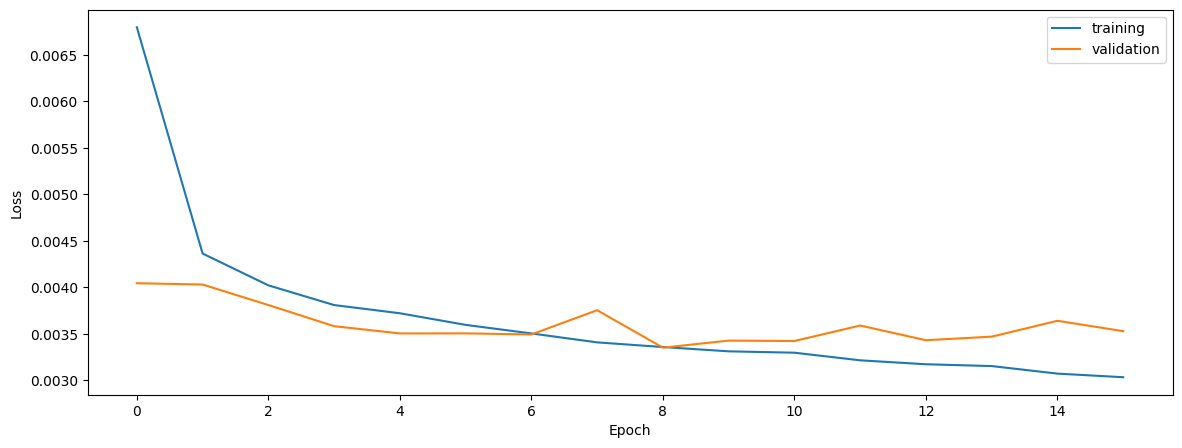

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.8213967558361484
0.8022584890218721
0.8023480899982676


In [8]:
print('native')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

native
0.8213967558361484
0.8022584890218721
0.8023480899982676


In [9]:
print('normalized')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

normalized
0.8249477912662292
0.8030462294914388
0.8063665402837974


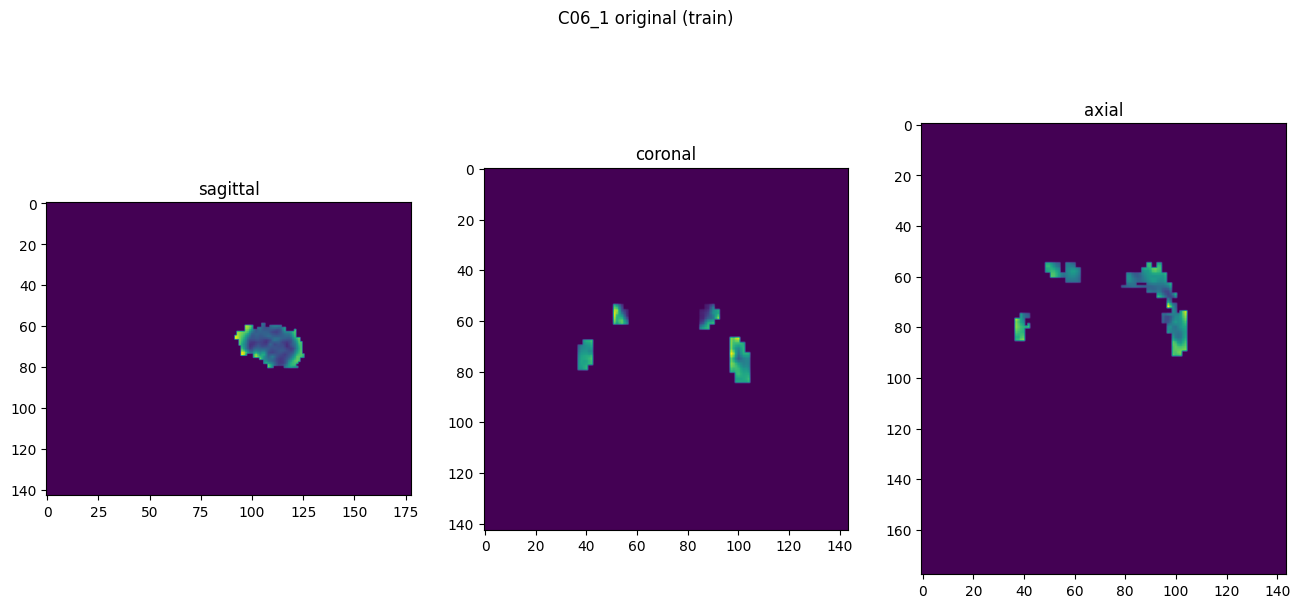

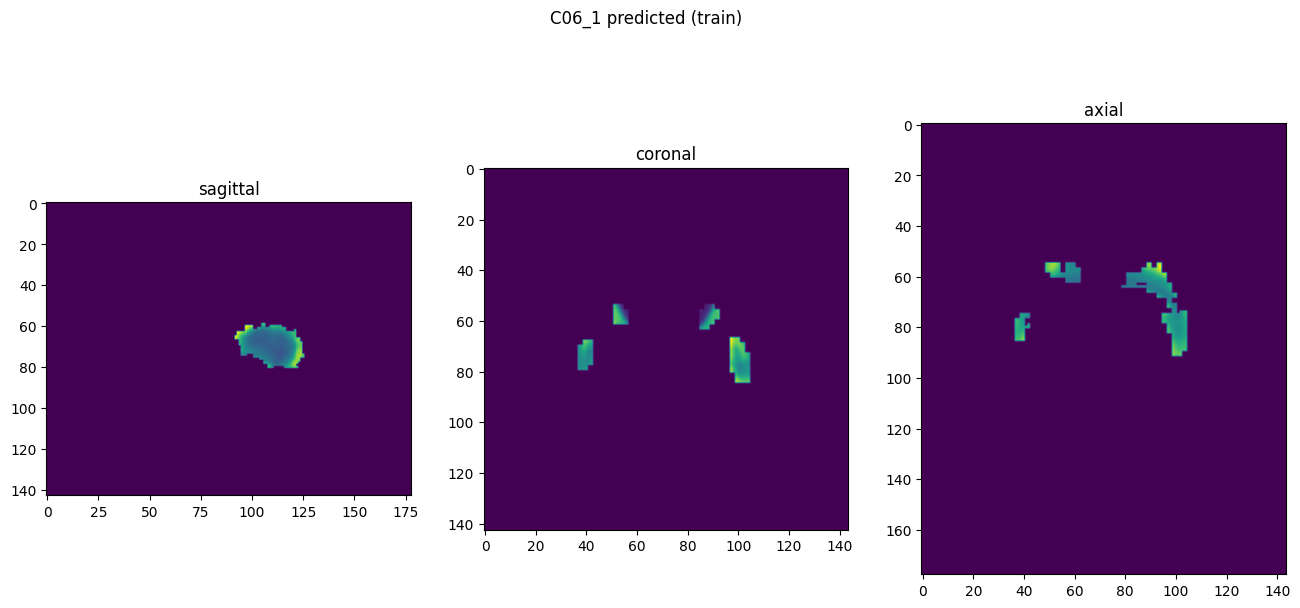

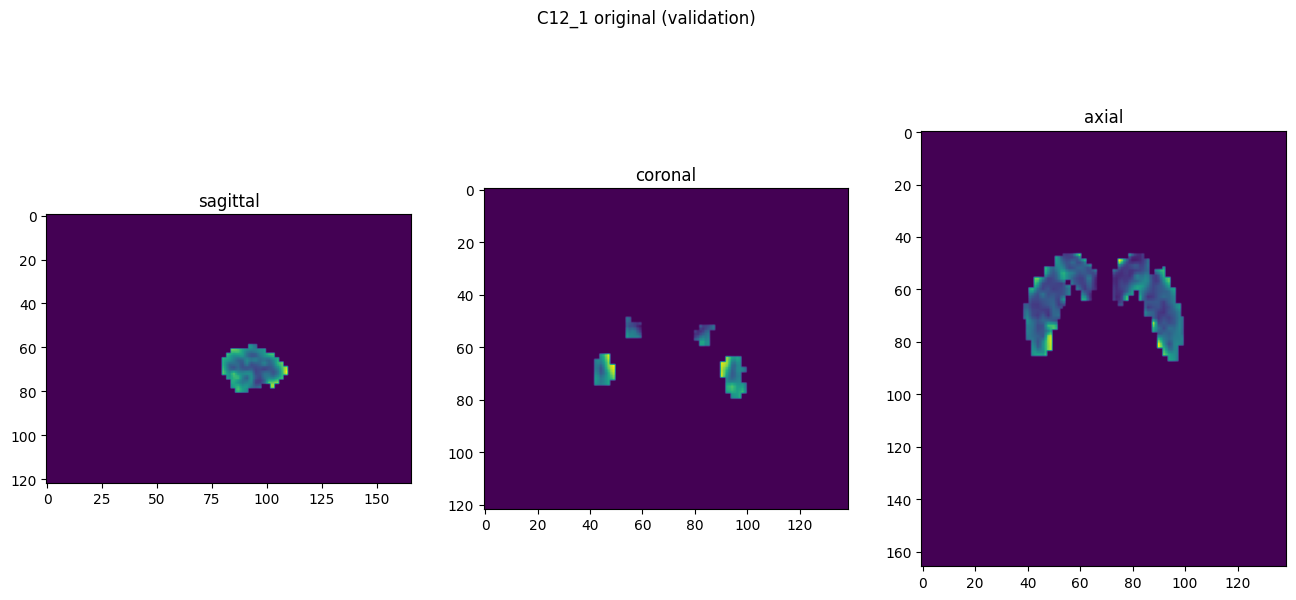

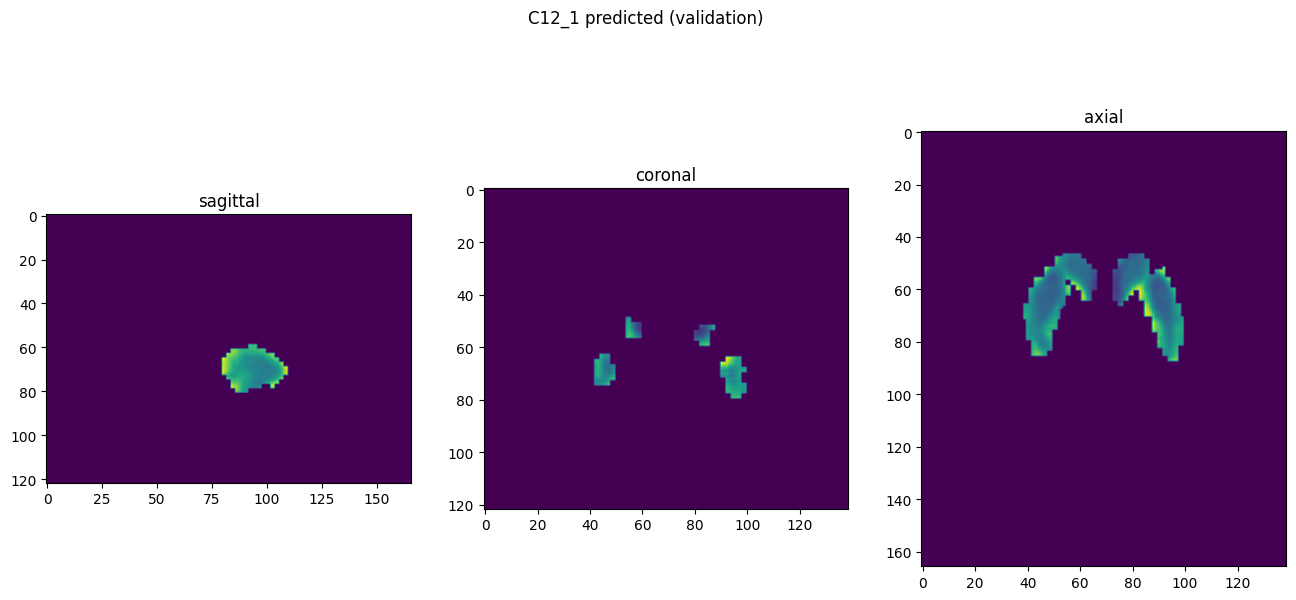

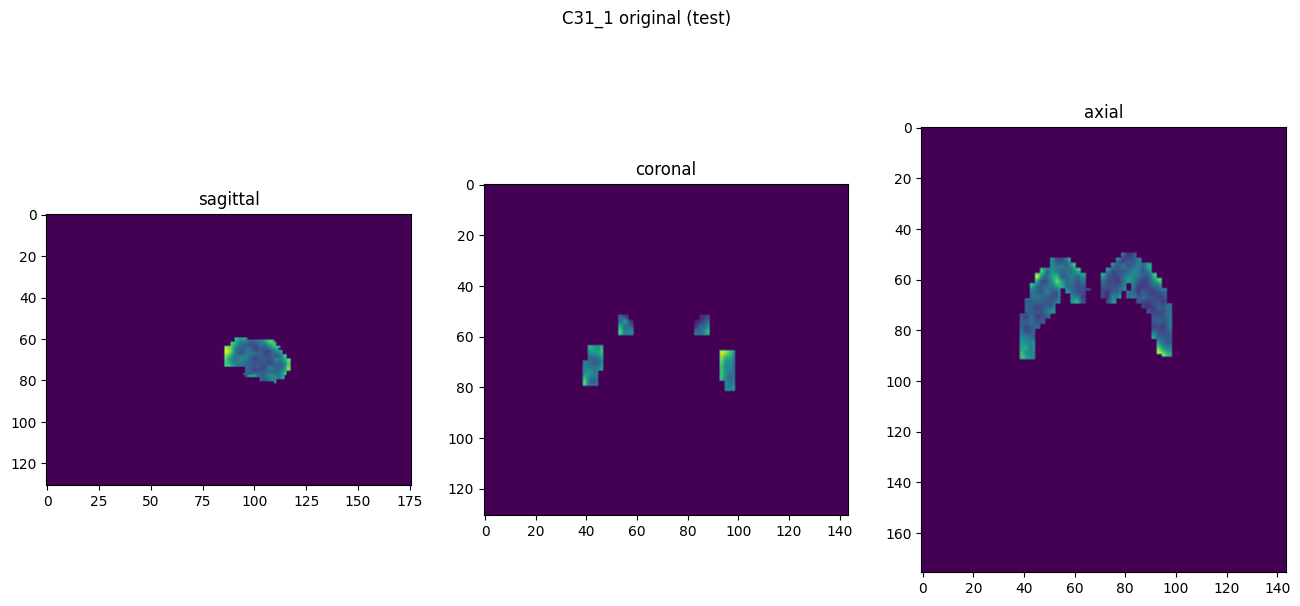

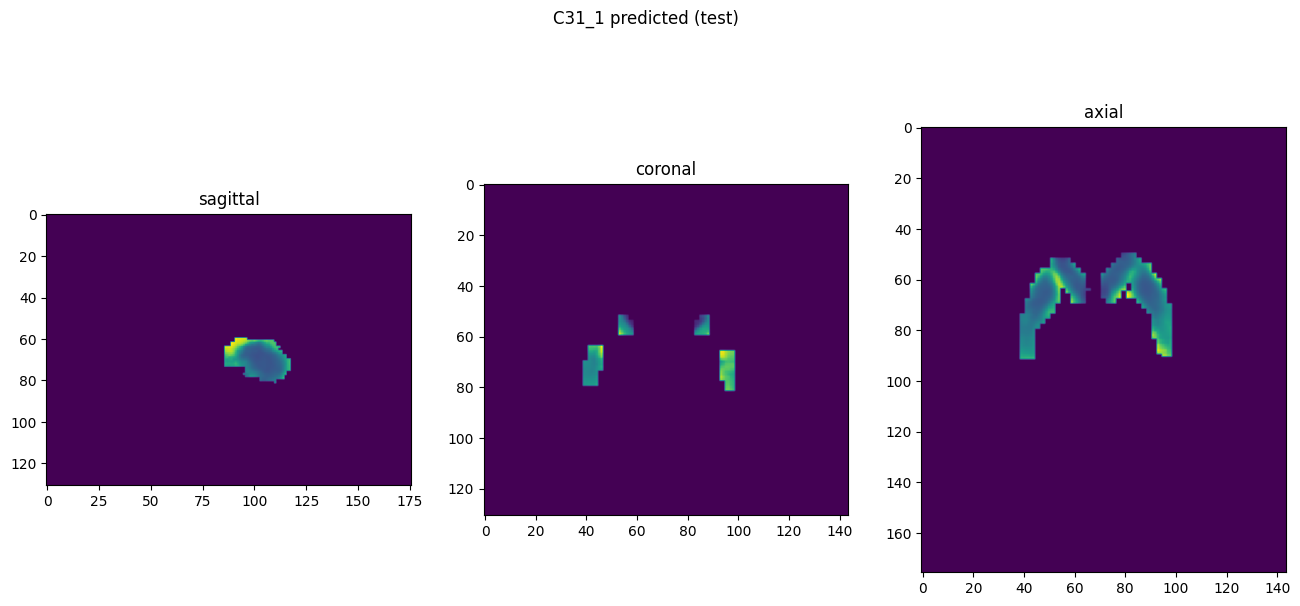

In [10]:
showResults(model, gen, threshold=None, background=False)